In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip -uq "/content/drive/My Drive/flower-photos.zip" -d "/content/drive/My Drive/flower-photos"

In [0]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
train_dir = '/content/drive/My Drive/flower-photos/flower_photos/train'
test_dir = '/content/drive/My Drive/flower-photos/flower_photos/test'


classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

In [0]:
# defining dataloader parameters
batch_size = 20
num_workers=0

# preparing data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

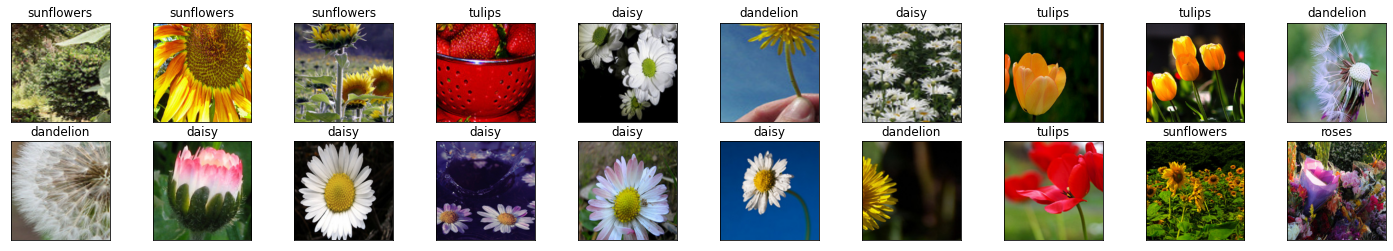

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # converting images to numpy for display

# ploting the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [9]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [10]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [12]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features


last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)


5


In [0]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [15]:
n_epochs = 5

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.4451522231101990
Epoch 1, Batch 40 loss: 1.3011361479759216
Epoch 1, Batch 60 loss: 1.1435235440731049
Epoch 1, Batch 80 loss: 1.0649476528167725
Epoch 1, Batch 100 loss: 1.0521251797676086
Epoch 1, Batch 120 loss: 0.9635294318199158
Epoch 1, Batch 140 loss: 0.9124546408653259
Epoch 2, Batch 20 loss: 0.8727136462926864
Epoch 2, Batch 40 loss: 0.8270269930362701
Epoch 2, Batch 60 loss: 0.7579382091760636
Epoch 2, Batch 80 loss: 0.7642968624830246
Epoch 2, Batch 100 loss: 0.7538802996277809
Epoch 2, Batch 120 loss: 0.8111694201827049
Epoch 2, Batch 140 loss: 0.7279854923486709
Epoch 3, Batch 20 loss: 0.7057655990123749
Epoch 3, Batch 40 loss: 0.6955325111746788
Epoch 3, Batch 60 loss: 0.6867611482739449
Epoch 3, Batch 80 loss: 0.6771330460906029
Epoch 3, Batch 100 loss: 0.6798183023929596
Epoch 3, Batch 120 loss: 0.6363913282752037
Epoch 3, Batch 140 loss: 0.6475440278649330
Epoch 4, Batch 20 loss: 0.6490623861551285
Epoch 4, Batch 40 loss: 0.6549754500389099
Ep

In [16]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.542007

Test Accuracy of daisy: 80% (74/92)
Test Accuracy of dandelion: 90% (119/132)
Test Accuracy of roses: 73% (67/91)
Test Accuracy of sunflowers: 83% (84/101)
Test Accuracy of tulips: 75% (94/124)

Test Accuracy (Overall): 81% (438/540)
